<h2 align="center">London Trial</h2>

***
The objective of this code is to establish a network of hyperlocal last-mile distribution depots around London for a grocery delivery start-up.<br>

This code begins by importing geographic and geometric data from the Borough of Hammersmith and Fulham. It then extracts the centroids of the neighbourhoods using the geometry given and produces a diagram showing the potential warehouse locations. The data is further analysed to obtain a shortlist of 5 warehouses with the highest population coverage.<br>

TASK 2 summary.<br>

TASK 3 summary.

<h3 align="center">Part 1 - Data Preparation</h3>

***

Importing Python packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#The following two packages are specifically important for creating  the plots in this code
from shapely.geometry import Point, Polygon, MultiPolygon
import geopandas as gpd

from sklearn.cluster import KMeans
from matplotlib import cm
from pulp import *

%matplotlib inline

#### TASK 1.1
Importing the main geometry data of the Lower Layer Super Output Areas (LSOAs) from the main *.shp file. The data from the region of Hammersmith and Fulham is then extracted and a 113x3 table of this data is outputted to be analysed further.

In [2]:
# Import data from lsoa shp file
ldn_df= gpd.read_file('LSOA_GreaterLondon.shp')

# Select warehouse in wanted districts
ldn_df=ldn_df[ldn_df['lsoa_name'].str.contains('Westminster|Kensington|City|Camden')]
ldn_df

,lsoa_code,lsoa_name,geometry
0,E01000001,City of London 001A,"POLYGON ((-0.09726 51.52158, -0.09649 51.52028..."
1,E01000002,City of London 001B,"POLYGON ((-0.08810 51.51941, -0.08927 51.51752..."
2,E01000003,City of London 001C,"POLYGON ((-0.09676 51.52325, -0.09644 51.52282..."
3,E01000005,City of London 001E,"POLYGON ((-0.07320 51.51000, -0.07551 51.50974..."
824,E01000842,Camden 011A,"POLYGON ((-0.16524 51.54730, -0.16468 51.54696..."
...,...,...,...
4791,E01033604,Westminster 009J,"POLYGON ((-0.17141 51.52136, -0.17077 51.52134..."
4792,E01033605,Westminster 009K,"POLYGON ((-0.17231 51.52529, -0.17264 51.52502..."
4793,E01033606,Westminster 014F,"POLYGON ((-0.19636 51.51907, -0.19609 51.51832..."
4794,E01033607,Westminster 014G,"POLYGON ((-0.19136 51.51972, -0.19165 51.51858..."


The population and geometric data is extracted, which will be needed to locate the potential warehouse locations using the centroids and rank them in terms of population coverage.

In [3]:
# Import data from excel
PC=pd.read_csv('population_and_centroids.csv')
PC


,Unnamed: 0,lsoa_code,lsoa_name,pop,centroid_id,latitude,longitude
0,0,E01000001,City of London 001A,1749,22842,51.519643,-0.096276
1,1,E01000002,City of London 001B,1678,22837,51.519636,-0.092408
2,2,E01000003,City of London 001C,1900,22839,51.522089,-0.095964
3,3,E01000005,City of London 001E,2181,22835,51.513031,-0.073842
4,4,E01032739,City of London 001F,1688,20480,51.511438,-0.094775
...,...,...,...,...,...,...,...
4830,4830,E01033604,Westminster 009J,1521,20636,51.521292,-0.170130
4831,4831,E01033605,Westminster 009K,2142,20637,51.523192,-0.172417
4832,4832,E01033606,Westminster 014F,1243,20634,51.518014,-0.196017
4833,4833,E01033607,Westminster 014G,1322,20635,51.517918,-0.194235


In [4]:
# Select row code indexes from ldn.df to be considered in PC
code_index=ldn_df['lsoa_code'].tolist()

# Select rows of PC by code index
H= PC[PC['lsoa_code'].isin(code_index)]
H

,Unnamed: 0,lsoa_code,lsoa_name,pop,centroid_id,latitude,longitude
0,0,E01000001,City of London 001A,1749,22842,51.519643,-0.096276
1,1,E01000002,City of London 001B,1678,22837,51.519636,-0.092408
2,2,E01000003,City of London 001C,1900,22839,51.522089,-0.095964
3,3,E01000005,City of London 001E,2181,22835,51.513031,-0.073842
4,4,E01032739,City of London 001F,1688,20480,51.511438,-0.094775
...,...,...,...,...,...,...,...
4830,4830,E01033604,Westminster 009J,1521,20636,51.521292,-0.170130
4831,4831,E01033605,Westminster 009K,2142,20637,51.523192,-0.172417
4832,4832,E01033606,Westminster 014F,1243,20634,51.518014,-0.196017
4833,4833,E01033607,Westminster 014G,1322,20635,51.517918,-0.194235


This data is then added into the Greater London dataframe in order to be analysed further. The updated dataframe is then outputted below. 

In [5]:
# Select population column from H
df=H['pop']

# Add population columns to ldn_df
ldn_df['pop'] =df.values
ldn_df

,lsoa_code,lsoa_name,geometry,pop
0,E01000001,City of London 001A,"POLYGON ((-0.09726 51.52158, -0.09649 51.52028...",1749
1,E01000002,City of London 001B,"POLYGON ((-0.08810 51.51941, -0.08927 51.51752...",1678
2,E01000003,City of London 001C,"POLYGON ((-0.09676 51.52325, -0.09644 51.52282...",1900
3,E01000005,City of London 001E,"POLYGON ((-0.07320 51.51000, -0.07551 51.50974...",2181
824,E01000842,Camden 011A,"POLYGON ((-0.16524 51.54730, -0.16468 51.54696...",1688
...,...,...,...,...
4791,E01033604,Westminster 009J,"POLYGON ((-0.17141 51.52136, -0.17077 51.52134...",1521
4792,E01033605,Westminster 009K,"POLYGON ((-0.17231 51.52529, -0.17264 51.52502...",2142
4793,E01033606,Westminster 014F,"POLYGON ((-0.19636 51.51907, -0.19609 51.51832...",1243
4794,E01033607,Westminster 014G,"POLYGON ((-0.19136 51.51972, -0.19165 51.51858...",1322


You can read in a shapefile the following way by refering to the *.shp file.

The current geometric data takes the curvature of the earth into account. In order to calculate the centroids, the geometric data needs to be 'flattened' in order to calculate the plane area for the LSOAs and to thus calculate the position of the centroids.

In [6]:
# To convert the geometry
ldn_geo_3035 = ldn_df['geometry'].to_crs(epsg=3035)
ldn_geo_3035.head()

0      POLYGON ((3622752.020 3205175.179, 3622785.117...
1      POLYGON ((3623347.578 3204848.398, 3623238.782...
2      POLYGON ((3622812.179 3205354.940, 3622827.250...
3      POLYGON ((3624226.440 3203667.543, 3624064.363...
824    POLYGON ((3618483.473 3208666.228, 3618516.209...
Name: geometry, dtype: geometry

In [7]:
ldn_geo_3035_centroids = ldn_geo_3035.centroid
ldn_geo_3035_centroids.head()

0      POINT (3622732.366 3204776.166)
1      POINT (3623025.554 3204758.729)
2      POINT (3622855.564 3205177.114)
3      POINT (3624103.524 3204083.299)
824    POINT (3618297.964 3208637.499)
dtype: geometry

In [8]:
ldn_geo_4326_centroids = ldn_geo_3035_centroids.to_crs(epsg=4326)
ldn_geo_4326_centroids.head()

0      POINT (-0.09675 51.51801)
1      POINT (-0.09253 51.51822)
2      POINT (-0.09579 51.52172)
3      POINT (-0.07578 51.51355)
824    POINT (-0.16783 51.54681)
dtype: geometry

In [9]:
centroids = gpd.GeoSeries(ldn_geo_4326_centroids, name='centroids')

The centroids data has now been calculated and can be appended onto the 3 districts data.

In [10]:
ldn_df = ldn_df.merge(centroids,left_index=True, right_index=True)
ldn_df.head()

,lsoa_code,lsoa_name,geometry,pop,centroids
0,E01000001,City of London 001A,"POLYGON ((-0.09726 51.52158, -0.09649 51.52028...",1749,POINT (-0.09675 51.51801)
1,E01000002,City of London 001B,"POLYGON ((-0.08810 51.51941, -0.08927 51.51752...",1678,POINT (-0.09253 51.51822)
2,E01000003,City of London 001C,"POLYGON ((-0.09676 51.52325, -0.09644 51.52282...",1900,POINT (-0.09579 51.52172)
3,E01000005,City of London 001E,"POLYGON ((-0.07320 51.51000, -0.07551 51.50974...",2181,POINT (-0.07578 51.51355)
824,E01000842,Camden 011A,"POLYGON ((-0.16524 51.54730, -0.16468 51.54696...",1688,POINT (-0.16783 51.54681)


With all the extracted data, the potential warehouse locations can be plotted.

In [11]:
# This is ensuring that any MultiPolygons have been separated into normal Polygons.
all_polygons = ldn_df.geometry.explode(index_parts=True)

# Initialise min x and y and max x and y with extreme values.
minx, miny, maxx, maxy = 50000, 50000, -50000, -50000

# Calculate the minimum and maximum longitudes (x), latitudes (y)
minx = min(min(list(map(list, zip(*list(n.exterior.coords))))[0]) for t,n in enumerate(all_polygons))
miny = min(min(list(map(list, zip(*list(n.exterior.coords))))[1]) for t,n in enumerate(all_polygons))
maxx = max(max(list(map(list, zip(*list(n.exterior.coords))))[0]) for t,n in enumerate(all_polygons))
maxy = max(max(list(map(list, zip(*list(n.exterior.coords))))[1]) for t,n in enumerate(all_polygons))



/var/folders/rw/5mn6h4bn5z18wdnwdjlb_tjr0000gn/T/ipykernel_91096/706191114.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm, shrink=0.7)


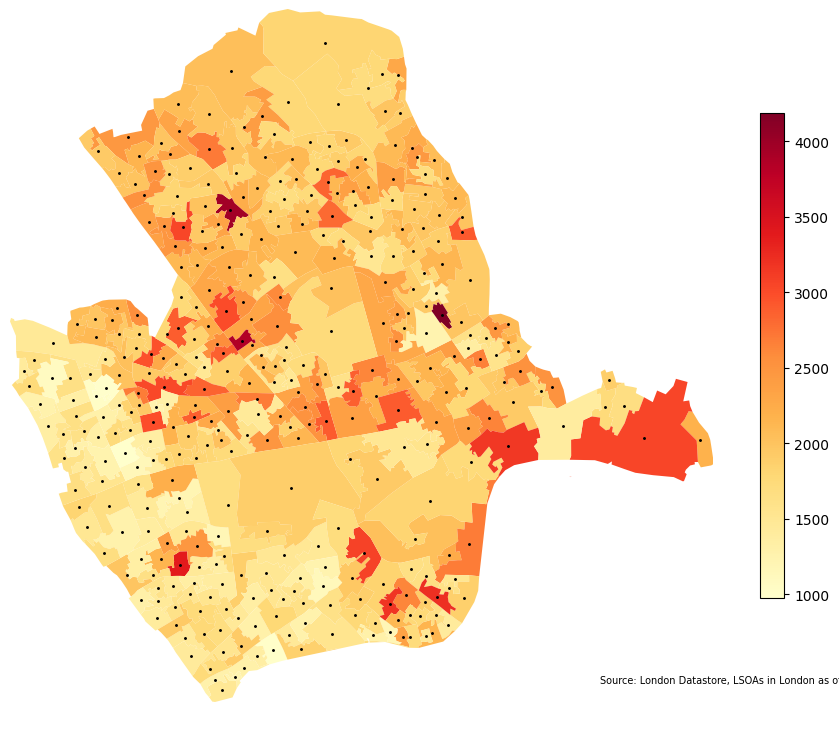

In [12]:
# Plotting
fig, ax = plt.subplots(1, figsize = (15,15))

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Add a title
#ax.set_title('Potential warehouse locations', fontdict={'fontsize': '14', 'fontweight': '2'})

# We will remove the axis for better presentation
ax.axis('off') 

# We will annotate and add source
ax.annotate('Source: London Datastore, LSOAs in London as of 2011',xy=(.5, .07),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=7, color='k')

# Plot using a rainbow colourmap
ldn_df.plot(ax=ax,alpha=1, column='pop', cmap='YlOrRd')
fig.set_size_inches(12, 9)
# Add colourbar
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=ldn_df['pop'].min(), vmax=ldn_df['pop'].max())) # Empty array for the data range
cbar = fig.colorbar(sm, shrink=0.7)


ldn_df['centroids'].plot(ax=ax, markersize=1.2, color='k',marker='o', label='Centroids'); # The semicolon is to suppress output info.
#legend = ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
fig.savefig('potential_locations.png')

#### TASK 1.2
Developing the code further to identify neighbourhoods that can be served by a warehouse established at any eligible location (centroid) in the borough.<br>

The range limitation for a warehouse is rangelim km.

In [13]:
rangelim=0.5

Using the haversine function definition to calculate the distance between two points, based on the radius of the earth at the latitude of London.

In [14]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    """
    
    r_earth = 6365.078
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = r_earth * c
    return km

In [15]:
# calculate distance between each centroid
dist = haversine_np(H['longitude'], H['latitude'], H['longitude'], H['latitude'])


dist_dict = {}
for k1, v1, w1 in zip(H['lsoa_code'], H['longitude'],H['latitude']):
    for k2, v2, w2 in zip(H['lsoa_code'], H['longitude'],H['latitude']):
        dist_dict[(k1,k2)] = haversine_np(v1,w1,v2,w2)
dist_dict

{('E01000001', 'E01000001'): 0.0,
 ('E01000001', 'E01000002'): 0.2673930524085902,
 ('E01000001', 'E01000003'): 0.27267476247453054,
 ('E01000001', 'E01000005'): 1.7160551688236727,
 ('E01000001', 'E01032739'): 0.9173433351197742,
 ('E01000001', 'E01032740'): 0.7524324274962625,
 ('E01000001', 'E01000842'): 5.786871101970847,
 ('E01000001', 'E01000843'): 5.471446464509547,
 ('E01000001', 'E01000844'): 5.89544850600787,
 ('E01000001', 'E01000845'): 5.394883928255001,
 ('E01000001', 'E01000846'): 5.458953683359912,
 ('E01000001', 'E01000847'): 5.720907218095058,
 ('E01000001', 'E01000848'): 5.993284582502325,
 ('E01000001', 'E01000849'): 5.812230772428831,
 ('E01000001', 'E01000850'): 2.4926908870071127,
 ('E01000001', 'E01000851'): 2.944394944160584,
 ('E01000001', 'E01000852'): 2.3490491039534263,
 ('E01000001', 'E01000853'): 2.0426969623678,
 ('E01000001', 'E01000854'): 2.803708375802164,
 ('E01000001', 'E01000855'): 2.032354866048538,
 ('E01000001', 'E01000856'): 4.11058059267331,
 (

Creating a dist_dict_eligible (in the form of a nested dictionary) showing all neighbourhoods that can be served by each warehouse, given the range limitation of rangelim km.<br> 

The dist_dict_eligible is outputted below, showing the combinations and distances between warehouses.

In [16]:
dist_dict_eligible = dict(filter(lambda elem: elem[1] <= rangelim, dist_dict.items())) # select only distances smaller than rangelim km
dist_dict_eligible # selected centroids with distance smaller than rangelim km

{('E01000001', 'E01000001'): 0.0,
 ('E01000001', 'E01000002'): 0.2673930524085902,
 ('E01000001', 'E01000003'): 0.27267476247453054,
 ('E01000002', 'E01000001'): 0.2673930524085902,
 ('E01000002', 'E01000002'): 0.0,
 ('E01000002', 'E01000003'): 0.36701467892102496,
 ('E01000003', 'E01000001'): 0.27267476247453054,
 ('E01000003', 'E01000002'): 0.36701467892102496,
 ('E01000003', 'E01000003'): 0.0,
 ('E01000005', 'E01000005'): 0.0,
 ('E01032739', 'E01032739'): 0.0,
 ('E01032740', 'E01032740'): 0.0,
 ('E01000842', 'E01000842'): 0.0,
 ('E01000842', 'E01000843'): 0.39835528655966557,
 ('E01000842', 'E01000844'): 0.31257912204807026,
 ('E01000842', 'E01000845'): 0.3919938456929241,
 ('E01000842', 'E01000846'): 0.38979850277775735,
 ('E01000842', 'E01000847'): 0.4422105028066789,
 ('E01000842', 'E01000848'): 0.24680167527401425,
 ('E01000842', 'E01000849'): 0.30808953553523927,
 ('E01000842', 'E01000882'): 0.4254856577599045,
 ('E01000843', 'E01000842'): 0.39835528655966557,
 ('E01000843', 'E

#### TASK 1.3
Taking the warehouses that now have the neighbourhoods that can be served within its reach, and using the population data to identify the top 5 warehouses.<br>

This top 5 is highlighted in the plot that is made. Arguments are then made for why these warehouses are not in the optimal locations. A more sophisticated model is needed to take into account more factors and variables.

First, the population data is extracted.

In [17]:
# Centroid for all warehouses
centroid = dict(zip(list(ldn_df['lsoa_code']), ldn_df['centroids']))
centroid

{'E01000001': <shapely.geometry.point.Point at 0x7f9e3b342880>,
 'E01000002': <shapely.geometry.point.Point at 0x7f9e3b3428e0>,
 'E01000003': <shapely.geometry.point.Point at 0x7f9e3b3428b0>,
 'E01000005': <shapely.geometry.point.Point at 0x7f9e3b342940>,
 'E01000842': <shapely.geometry.point.Point at 0x7f9e3b342970>,
 'E01000843': <shapely.geometry.point.Point at 0x7f9e3b3429a0>,
 'E01000844': <shapely.geometry.point.Point at 0x7f9e3b3429d0>,
 'E01000845': <shapely.geometry.point.Point at 0x7f9e3b342a00>,
 'E01000846': <shapely.geometry.point.Point at 0x7f9e3b342730>,
 'E01000847': <shapely.geometry.point.Point at 0x7f9e3b342a30>,
 'E01000848': <shapely.geometry.point.Point at 0x7f9e3b342a60>,
 'E01000849': <shapely.geometry.point.Point at 0x7f9e3b342a90>,
 'E01000850': <shapely.geometry.point.Point at 0x7f9e3b3427f0>,
 'E01000851': <shapely.geometry.point.Point at 0x7f9e3b342ac0>,
 'E01000852': <shapely.geometry.point.Point at 0x7f9e3b342af0>,
 'E01000853': <shapely.geometry.point.Po

In [18]:
# Calculate population
population = {}
for k1, v1 in centroid.items():
    pop = 0
    for k2, v2 in centroid.items():
        if dist_dict[(k1,k2)] <= rangelim :
            row = ldn_df[ldn_df['lsoa_code'].str.contains(k2)] 
            pop += int(row['pop'])
    
    population[k1] = pop

population = {y:x for x,y in population.items()}
population


{5327: 'E01000003',
 2181: 'E01000005',
 17243: 'E01000842',
 19182: 'E01000843',
 15866: 'E01000844',
 12153: 'E01000845',
 15245: 'E01000846',
 11903: 'E01000847',
 13597: 'E01000848',
 11099: 'E01000849',
 12878: 'E01000850',
 11576: 'E01000851',
 13627: 'E01000852',
 15535: 'E01000853',
 9920: 'E01000854',
 13963: 'E01000855',
 13324: 'E01000856',
 14705: 'E01000857',
 7309: 'E01000858',
 9964: 'E01004733',
 7157: 'E01000860',
 13464: 'E01000861',
 9077: 'E01000862',
 7457: 'E01000863',
 9037: 'E01000864',
 13867: 'E01000865',
 11698: 'E01000866',
 11809: 'E01000867',
 6799: 'E01000868',
 8189: 'E01000869',
 13784: 'E01000870',
 8569: 'E01000871',
 6401: 'E01000872',
 13123: 'E01000873',
 12905: 'E01000874',
 13106: 'E01000875',
 11216: 'E01000876',
 11326: 'E01000877',
 8729: 'E01000878',
 12817: 'E01000879',
 8519: 'E01000880',
 10033: 'E01000881',
 13462: 'E01000882',
 11920: 'E01000883',
 4415: 'E01000884',
 1999: 'E01000885',
 11425: 'E01000886',
 9324: 'E01000887',
 11034: 'E

Selecting the top 5 warehouses ranked by largest population coverage and outputting them. Using the warehouse codes, their centroids need to be found in order to include them in the plot.

In [19]:
# Select top 5 warehouse locations with largest population coverage
top5 = sorted(population.keys(), reverse = True)[0:5]
top5_code = [population[key] for key in top5]
top5_code

['E01004742', 'E01004752', 'E01004756', 'E01004751', 'E01004718']

In [20]:
top5_df = ldn_df[ldn_df['lsoa_code'].isin(top5_code)]

In [21]:
top5_df

,lsoa_code,lsoa_name,geometry,pop,centroids
4597,E01004718,Westminster 004A,"POLYGON ((-0.20251 51.52910, -0.20145 51.52894...",1953,POINT (-0.20451 51.52810)
4621,E01004742,Westminster 022A,"POLYGON ((-0.13683 51.49043, -0.13561 51.48985...",1759,POINT (-0.13772 51.48921)
4630,E01004751,Westminster 022C,"POLYGON ((-0.14162 51.49253, -0.14198 51.49219...",3182,POINT (-0.14440 51.49089)
4631,E01004752,Westminster 022D,"POLYGON ((-0.13988 51.49086, -0.13966 51.49069...",1779,POINT (-0.14000 51.48935)
4635,E01004756,Westminster 006E,"POLYGON ((-0.19022 51.52336, -0.19127 51.52313...",1958,POINT (-0.19181 51.52402)


In [22]:
centroid_main=dict(zip(list(top5_df['lsoa_code']), top5_df['centroids']))

In [23]:
coverage_nei_matrix = {}
for k1, v1 in centroid_main.items():
    coverage_nei_matrix[k1] = {}
    for k2, v2 in centroid.items():
        if dist_dict[(k1,k2)] <= rangelim:
            coverage_nei_matrix[k1][k2] = 1

Plotting the potential warehouse locations but now with the top 5 ranked warehouses in terms of population coverage labelled with a star.

In [24]:
# Plotting

# This is ensuring that any MultiPolygons have been separated into normal Polygons.
all_polygons = ldn_df.geometry.explode(index_parts=True)

# Initialise min x and y and max x and y with extreme values.
minx, miny, maxx, maxy = 50000, 50000, -50000, -50000

# Calculate the minimum and maximum longitudes (x), latitudes (y)
minx = min(min(list(map(list, zip(*list(n.exterior.coords))))[0]) for t,n in enumerate(all_polygons))
miny = min(min(list(map(list, zip(*list(n.exterior.coords))))[1]) for t,n in enumerate(all_polygons))
maxx = max(max(list(map(list, zip(*list(n.exterior.coords))))[0]) for t,n in enumerate(all_polygons))
maxy = max(max(list(map(list, zip(*list(n.exterior.coords))))[1]) for t,n in enumerate(all_polygons))


/var/folders/rw/5mn6h4bn5z18wdnwdjlb_tjr0000gn/T/ipykernel_91096/554016925.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm, shrink=0.5)


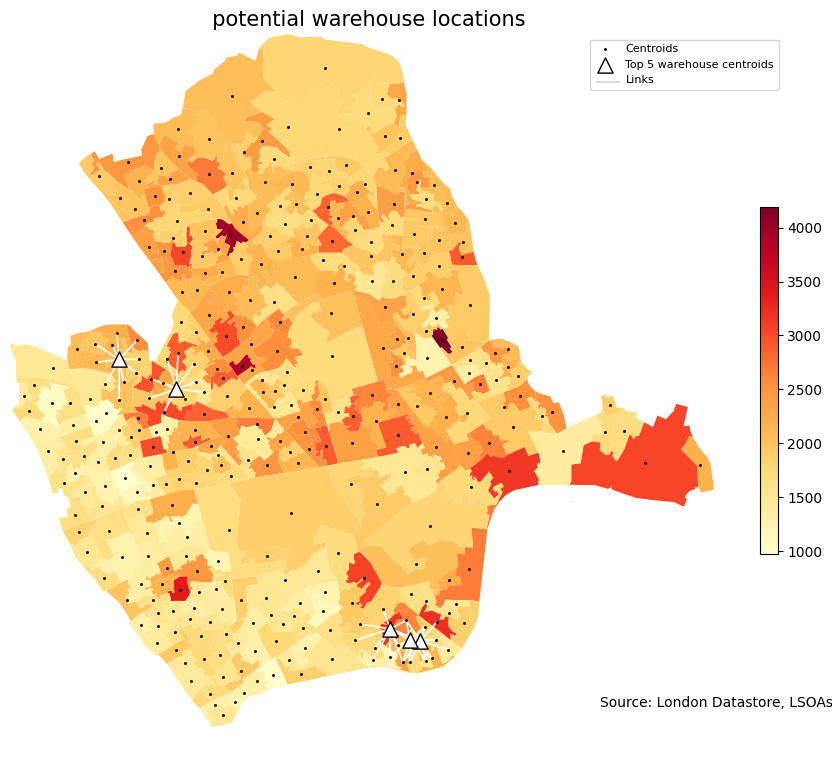

In [25]:
fig, ax = plt.subplots(1, figsize = (15,15))

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Add a title
ax.set_title('  potential warehouse locations', fontdict={'fontsize': '15', 'fontweight': '3'})

# We will remove the axis for better presentation
ax.axis('off') 

# We will annotate and add source
ax.annotate('Source: London Datastore, LSOAs in London as of 2011',xy=(.5, .07),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=10, color='k')

# Plot using a rainbow colormap
ldn_df.plot(ax=ax,alpha=1,column='pop', cmap='YlOrRd')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=ldn_df['pop'].min(), vmax=ldn_df['pop'].max())) # Empty array for the data range
cbar = fig.colorbar(sm, shrink=0.5)

# All potential warehouse location
ldn_df['centroids'].plot(ax=ax, markersize=1.2, color='k',marker='o',label='Centroids', zorder=120);

# 5 selected potential warehouse locations ranked by population coverage
top5_df['centroids'].plot(ax=ax, markersize=120, color='w',marker="^", edgecolor='black', label='Top 5 warehouse centroids', zorder=120);
# plot connection
for k1,v1 in centroid_main.items():
    for k2,v2 in centroid.items():
        if k2 in coverage_nei_matrix[k1]:
            ax.plot([v1.x, v2.x],[v1.y,v2.y], color='w',alpha=1, linewidth=1.2)
# plt.axis('scaled')
import matplotlib.patheffects as pe        
plt.plot([], [], color='w', path_effects=[pe.SimpleLineShadow(shadow_color='grey'), pe.Normal()], label='Links')
legend = ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1), prop={'size': 8})
fig.set_size_inches(12, 9)


**Reasons why a more sophisticated model is needed to select more optimal warehouse locations is seen below:**

The shortlist of the 5 warehouses would not be a good ideal as from the map we can see that 3 warehouses are close to each other. Therefore, the population and coverage may overlap, thus reduce the total amount of people and neighborhoods in a borough that can be served.<br>

Furthermore, the goal of delivery times of 7 mins or less is not necessarily achieved if the neighbourhoods are within the rangelim km limit. Consideration of the current transport network in that area should affect the range limit and including this would make the model more accurate.<br>

In addition, at this stage of the model, there is no consideration of the demand for groceries in each neighbourhood. Thus, if there is an area of high demand, there should be a depot in good proximity to it and vice versa.This would also mean that financially, the depots selected will bring maximal returns rather than just considering distance and population with no economic considerations.<br>

As a result, a more sophisticated selection facility strategy should be developed to ensure:<br>

1) there is no overlap of serving the same neighbourhood with two different warehouses.<br>

2) current transport links in that region is considered when determining the range limit, rather than just distance.<br>

3) the grocery demand in each region is considered to make sure the warehouse location selection is economically viable

## TASK 2.2 

#### Define problem

In [26]:
prob = LpProblem('prob', LpMaximize)

#### Getting individual locations of warehouses

In [27]:
locations=ldn_df[['lsoa_code']]
locations=locations.sort_values('lsoa_code') #sort values by warehouse
locations=locations.values.tolist()
locations = list(itertools.chain.from_iterable(locations))

L = locations #These tells us all possible warehouse and neighbourhood locations
N = locations
dict_locations= dict(zip(sorted(locations), L)) #Creating a dictionary for locations

#### Coverage dictionary

In [28]:
locations = list(dict.fromkeys(dist_dict_eligible)) 
locations = list(itertools.chain.from_iterable(locations)) #This turns the locations dictionary into an iterable list to loop throgh


even = locations[::2] #Setting up index parameters to be used in a loop
odd= locations[1::2]
index=np.ones(len(odd))
index=index.tolist()
index = [round(num) for num in index]


from collections import defaultdict #Creating coverage dictionary A

d = defaultdict(dict) #This uses deafultdict from 1.2 to establish, relatively, which locations are within rangelim km of one another

for x, y, z in zip(even, odd, index):
    d[x][y] = z
    
A=dict(d) #This tells us for a given location which other locations are within rangelim km 
    
import pprint
pprint.pprint(A) #print coverage dictionary


{'E01000001': {'E01000001': 1, 'E01000002': 1, 'E01000003': 1},
 'E01000002': {'E01000001': 1, 'E01000002': 1, 'E01000003': 1},
 'E01000003': {'E01000001': 1, 'E01000002': 1, 'E01000003': 1},
 'E01000005': {'E01000005': 1},
 'E01000842': {'E01000842': 1,
               'E01000843': 1,
               'E01000844': 1,
               'E01000845': 1,
               'E01000846': 1,
               'E01000847': 1,
               'E01000848': 1,
               'E01000849': 1,
               'E01000882': 1},
 'E01000843': {'E01000842': 1,
               'E01000843': 1,
               'E01000845': 1,
               'E01000846': 1,
               'E01000849': 1,
               'E01000892': 1,
               'E01000902': 1,
               'E01000903': 1,
               'E01000906': 1},
 'E01000844': {'E01000842': 1,
               'E01000844': 1,
               'E01000846': 1,
               'E01000847': 1,
               'E01000848': 1,
               'E01000882': 1,
               'E01000883': 1,

#### Demand dictionary

The demand for the two initial months are calculated using the following formula:

$$
D_{i}=P_{i}\times \frac{log_{10}(3)}{10}
$$

Where $P_{i}$ corresponds to the population of the selected stations.

In [29]:
D=ldn_df[['lsoa_code', 'pop']]
D=D.sort_values('lsoa_code') #sort values by warehouse, obtaining profit
D=D.values.tolist()

D = list(itertools.chain.from_iterable(D))

def listToDict(D):
    op = {D[i]: D[i + 1] for i in range(0, len(D), 2)}
    return op
D= listToDict(D)

#multiply population to get demand using formula in brief
import math
for key in D:    
    D[key] *=  math.log10(3+3*0)/10 #t is equal to 0 months, this then allows us to get the total demand 

#### Dictionary of costs (optional) 
Cost is the $C_{i}=3000$ for all warehouses.

In [30]:
Ci=3000

In [31]:
name= PC[['lsoa_code']]
name=name.sort_values('lsoa_code') #sort values by warehouse
name=name.values.tolist()
name = [item for sublist in name for item in sublist] #flatten list 

cost=Ci*np.ones(len(name))#This creates a cost dictionary, telling us the cost associated for each warehouse expansion, in our case this is just £Ci
cost=cost.tolist()
cost = [round(num) for num in cost]
C=dict(zip(name,cost))
C=dict((value,C[key]) for (key, value) in dict_locations.items())


#### Declaring decision variables

In [32]:
x = LpVariable.dicts('x', L, lowBound = 0, upBound = 1, cat = LpInteger) #These are binary so can only take values of 0 and 1
y = LpVariable.dicts('y', N, lowBound = 0, upBound = 1, cat = LpInteger)

#### Declaring objectives
$C_{i}$ can be simply replaced by 6000

In [33]:
initial_budget=6000

In [34]:
prob += 20*lpSum([D[j]*y[j]] for j in N) - lpSum(C[i]*x[i] for i in L) #This is the objective function, this is what must be maximised (profit)

prob += lpSum(C[i]*x[i] for i in L) <= initial_budget #Cost constraint, initial budget of initial_budget

#The remaining constraints, these limits values x and y can take based on certain conditions, see model for more explanation
for i in L:
    for j in N:
        if j in A[i]:
            prob += A[i][j]*x[i] <= y[j]

for j in N:
    prob += y[j] <= lpSum(A[i][j]*x[i] for i in L if j in A[i] if i in A.keys() )

#### Solving problem

In [35]:
prob.solve() #Solving the PuLP function
profit=round(prob.objective.value())
print('Total profit: £', round(prob.objective.value()))

print('')

print('Established Warehouses:\n')
L_new=()
N_new=()
for v in list(x.values()):
    if v.varValue == 1:
        L_new += (v.name.replace("x_",""),)
        print(f'  - {v.name.replace("x_","")} ')
        
for w in list(y.values()) :
    if w.varValue == 1:
        L_new += (v.name.replace("y_",""),)
            


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mayar/opt/anaconda3/envs/Mayarandom/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rw/5mn6h4bn5z18wdnwdjlb_tjr0000gn/T/dcb5ac79445d45febfd0c953c1d51409-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/rw/5mn6h4bn5z18wdnwdjlb_tjr0000gn/T/dcb5ac79445d45febfd0c953c1d51409-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2754 COLUMNS
At line 12849 RHS
At line 15599 BOUNDS
At line 16340 ENDATA
Problem MODEL has 2749 rows, 740 columns and 7874 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 42729.3 - 0.02 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 0 strengthened rows, 36 substitutions
Cgl0004I processed model has 2679 rows, 715 columns (715 integer (715 of which binary)) and 7690 elements
Cbc0038I Initial state - 0 integers unsatisfie

In [36]:
warehouses = []
neighbourhoods = []

for v in list(x.values()):
    #v_st = int(v.name.replace('v_x_',''))
    if v.varValue== 1:
        warehouses.append(v.name.replace('x_',''))
    

for v in list(y.values()):
    #v_st = int(v.name.replace('v_x_',''))
    if v.varValue== 1:
        neighbourhoods.append(v.name.replace('y_',''))
        
D        

{'E01000001': 83.44850745046897,
 'E01000002': 80.06094654195935,
 'E01000003': 90.65303839673587,
 'E01000005': 104.06014565435838,
 'E01000842': 80.53806779667902,
 'E01000843': 83.1145225721652,
 'E01000844': 89.12625038163294,
 'E01000845': 94.94712968921283,
 'E01000846': 103.48760014869478,
 'E01000847': 92.46609916467058,
 'E01000848': 82.49426494102964,
 'E01000849': 97.04646320997934,
 'E01000850': 104.96667603832574,
 'E01000851': 93.84975080335761,
 'E01000852': 115.36791939121439,
 'E01000853': 126.86654162995825,
 'E01000854': 102.62878189019939,
 'E01000855': 85.2138560929317,
 'E01000856': 100.76800899679272,
 'E01000857': 83.8302044542447,
 'E01000858': 93.9928871797735,
 'E01000859': 81.30146180423048,
 'E01000860': 104.25099415624625,
 'E01000861': 90.65303839673587,
 'E01000862': 72.093021588141,
 'E01000863': 81.44459818064638,
 'E01000864': 95.09026606562873,
 'E01000865': 95.56738732034839,
 'E01000866': 92.32296278825469,
 'E01000867': 94.18373568166136,
 'E01000

## Plotting graph for for task 2.2

/var/folders/rw/5mn6h4bn5z18wdnwdjlb_tjr0000gn/T/ipykernel_91096/965129744.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm, shrink=0.7)


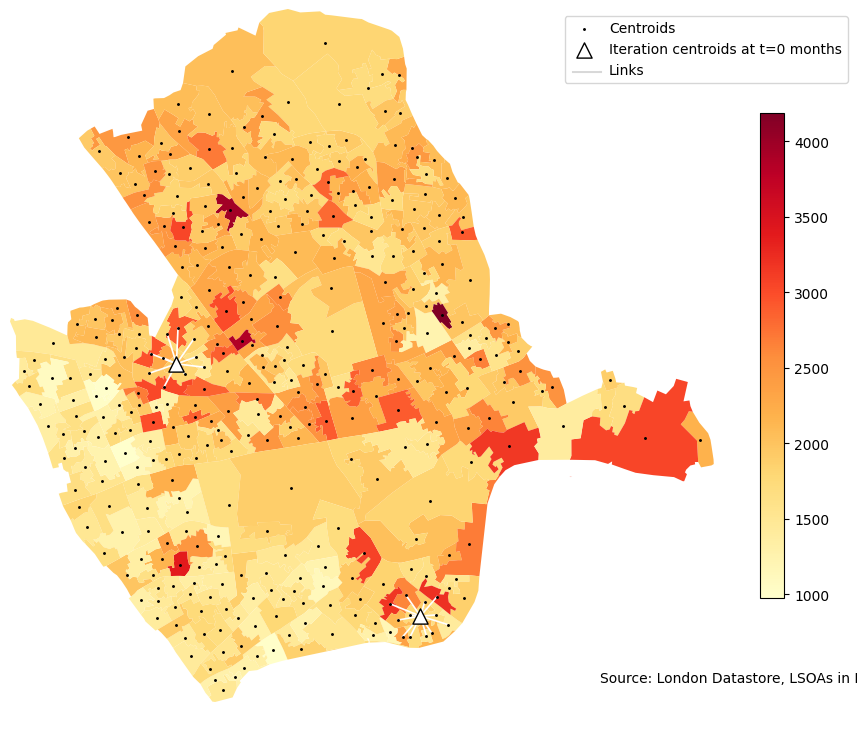

In [37]:
fig, ax = plt.subplots(1, figsize = (12,12))

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Add a title
#ax.set_title('Potential Warehouse Locations at start of period, t = 0 months', fontdict={'fontsize': '14', 'fontweight': '2'})

# We will remove the axis for better presentation
ax.axis('off') 

# We will annotate and add source
ax.annotate('Source: London Datastore, LSOAs in London as of 2011',xy=(.5, .07),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=10, color='k')

# Plot using a rainbow colormap
ldn_df.plot(ax=ax,alpha=1,column='pop', cmap='YlOrRd')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=ldn_df['pop'].min(), vmax=ldn_df['pop'].max())) # Empty array for the data range
cbar = fig.colorbar(sm, shrink=0.7)

# Plot all potential warehouse location
ldn_df['centroids'].plot(ax=ax, markersize=1.2, color='k',marker='o',label='Centroids', zorder=120);

#extarct all centroids 
centroids_all = ldn_df

#extarct centroids corresponding to warehouses at time t
centroids_set = ldn_df[ldn_df['lsoa_code'].isin(warehouses)] 
centroids_set['centroids'].plot(ax=ax, markersize=120, color='w',marker="^", edgecolor='k', label='Iteration centroids at t=0 months', zorder=120)

# Select centroids within rangelim km radius range from iterated centroids
mydict={};
for i in centroids_all.values.tolist():
    sel_centroids = { k: v for k, v in dist_dict_eligible.items() if k[0] == i }
    mydict.update(sel_centroids)

#COVERAGE MATRIX
locations = list(dict.fromkeys(dist_dict_eligible))
locations = list(itertools.chain.from_iterable(locations))
even = locations[::2] 
odd= locations[1::2]
index=np.ones(len(odd))
index=index.tolist()
index = [round(num) for num in index]
from collections import defaultdict
d = defaultdict(dict)
for x, y, z in zip(even, odd, index):
    d[x][y] = z
A=dict(d)

# Connect the randomsingle centroid with the other chosen centroids
for k1,v1 in centroids_set.set_index(['lsoa_code'])['centroids'].items():
    for k2,v2 in centroids_all.set_index(['lsoa_code'])['centroids'].items():
        if k2 in A[k1]:
            ax.plot([v1.x, v2.x],[v1.y,v2.y], color='w',alpha=1, linewidth=1.2)

import matplotlib.patheffects as pe        
plt.plot([], [], color='w', path_effects=[pe.SimpleLineShadow(shadow_color='grey'), pe.Normal()], label='Links')
legend = ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
fig.set_size_inches(12, 9)


## Task 3

#### Explanation

This follows the principles outlined in the explanations of the mathematical model adopted. The profit parameter is fed in from 2.2 and used as a constraint. The code is then looped over for months 2,4,6,8 and 10 to produce a series of graphs showing the networks expanding. The code also outputs the profit due to new warehouses and the profit due to established warehouses. It is worth noting that the growth slows down once there's full network coverage and no more warehouses to expand to, this results in profit growing only as a function of time. Hence for t=10 and t=12, there is only a small increase in profit, this contrasts significantly with the substantial increase in profit observe for the initial months.

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mayar/opt/anaconda3/envs/Mayarandom/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rw/5mn6h4bn5z18wdnwdjlb_tjr0000gn/T/ec2f6f899d29465d8a5137b19f93d8ad-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/rw/5mn6h4bn5z18wdnwdjlb_tjr0000gn/T/ec2f6f899d29465d8a5137b19f93d8ad-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2508 COLUMNS
At line 11833 RHS
At line 14337 BOUNDS
At line 15052 ENDATA
Problem MODEL has 2503 rows, 714 columns and 7182 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 83934.9 - 0.01 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 0 strengthened rows, 34 substitutions
Cgl0004I processed model has 2442 rows, 693 columns (693 integer (693 of which binary)) and 7026 elements
Cbc0038I Initial state - 11 integers unsatisfi

/var/folders/rw/5mn6h4bn5z18wdnwdjlb_tjr0000gn/T/ipykernel_91096/2492489.py:93: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm, shrink=0.7)


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mayar/opt/anaconda3/envs/Mayarandom/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rw/5mn6h4bn5z18wdnwdjlb_tjr0000gn/T/da0b3b407d52427fbb3360c53f5db3bf-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/rw/5mn6h4bn5z18wdnwdjlb_tjr0000gn/T/da0b3b407d52427fbb3360c53f5db3bf-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2317 COLUMNS
At line 11039 RHS
At line 13352 BOUNDS
At line 14043 ENDATA
Problem MODEL has 2312 rows, 690 columns and 6651 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 371409 - 0.03 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 0 strengthened rows, 34 substitutions
Cgl0004I processed model has 2251 rows, 660 columns (660 integer (660 of which binary)) and 6486 elements
Cbc0038I Initial state - 11 integers unsatisfie

/var/folders/rw/5mn6h4bn5z18wdnwdjlb_tjr0000gn/T/ipykernel_91096/2492489.py:93: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm, shrink=0.7)


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mayar/opt/anaconda3/envs/Mayarandom/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rw/5mn6h4bn5z18wdnwdjlb_tjr0000gn/T/4d39435fb56d4808b01dd9b2a72e7681-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/rw/5mn6h4bn5z18wdnwdjlb_tjr0000gn/T/4d39435fb56d4808b01dd9b2a72e7681-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1675 COLUMNS
At line 8364 RHS
At line 10035 BOUNDS
At line 10643 ENDATA
Problem MODEL has 1670 rows, 607 columns and 4867 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 788396 - 0.01 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 0 strengthened rows, 32 substitutions
Cgl0004I processed model has 1616 rows, 565 columns (565 integer (565 of which binary)) and 4708 elements
Cbc0038I Initial state - 11 integers unsatisfied

/var/folders/rw/5mn6h4bn5z18wdnwdjlb_tjr0000gn/T/ipykernel_91096/2492489.py:93: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm, shrink=0.7)


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mayar/opt/anaconda3/envs/Mayarandom/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rw/5mn6h4bn5z18wdnwdjlb_tjr0000gn/T/ec85daffa6434d5780adbfd2d2f610bf-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/rw/5mn6h4bn5z18wdnwdjlb_tjr0000gn/T/ec85daffa6434d5780adbfd2d2f610bf-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 377 COLUMNS
At line 2883 RHS
At line 3256 BOUNDS
At line 3659 ENDATA
Problem MODEL has 372 rows, 402 columns and 1299 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 265778 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 0 strengthened rows, 22 substitutions
Cgl0004I processed model has 348 rows, 238 columns (238 integer (238 of which binary)) and 1093 elements
Cbc0038I Initial state - 0 integers unsatisfied sum -

/var/folders/rw/5mn6h4bn5z18wdnwdjlb_tjr0000gn/T/ipykernel_91096/2492489.py:93: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm, shrink=0.7)


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mayar/opt/anaconda3/envs/Mayarandom/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rw/5mn6h4bn5z18wdnwdjlb_tjr0000gn/T/7576ccb47e8d474aae817a321eb13724-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/rw/5mn6h4bn5z18wdnwdjlb_tjr0000gn/T/7576ccb47e8d474aae817a321eb13724-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 6 COLUMNS
At line 1171 RHS
At line 1173 BOUNDS
At line 1465 ENDATA
Problem MODEL has 1 rows, 291 columns and 291 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 0 to -1.79769e+308
Probing was tried 0 times and created 0 cuts

/var/folders/rw/5mn6h4bn5z18wdnwdjlb_tjr0000gn/T/ipykernel_91096/2492489.py:93: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm, shrink=0.7)


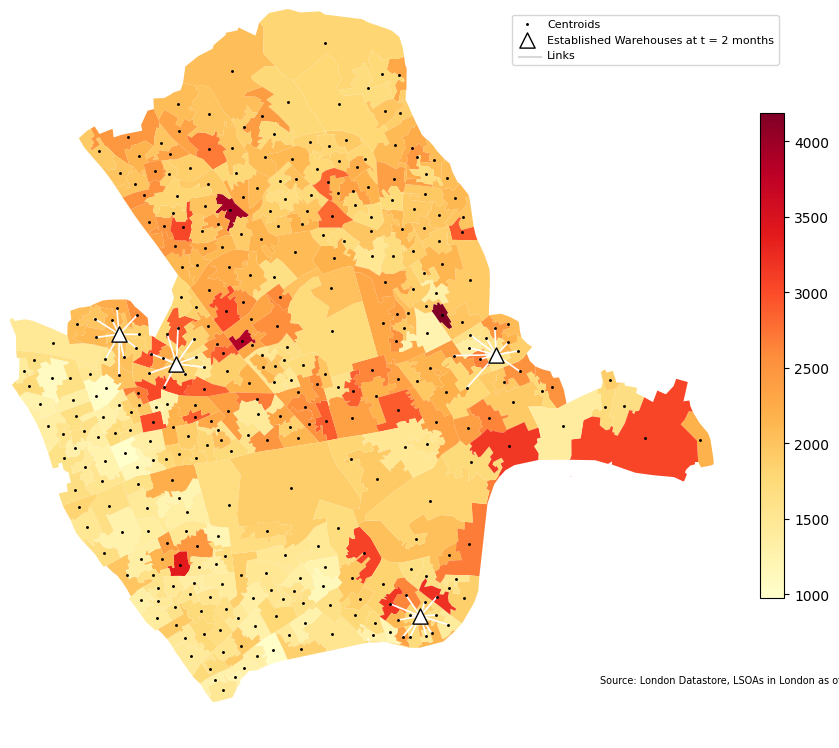

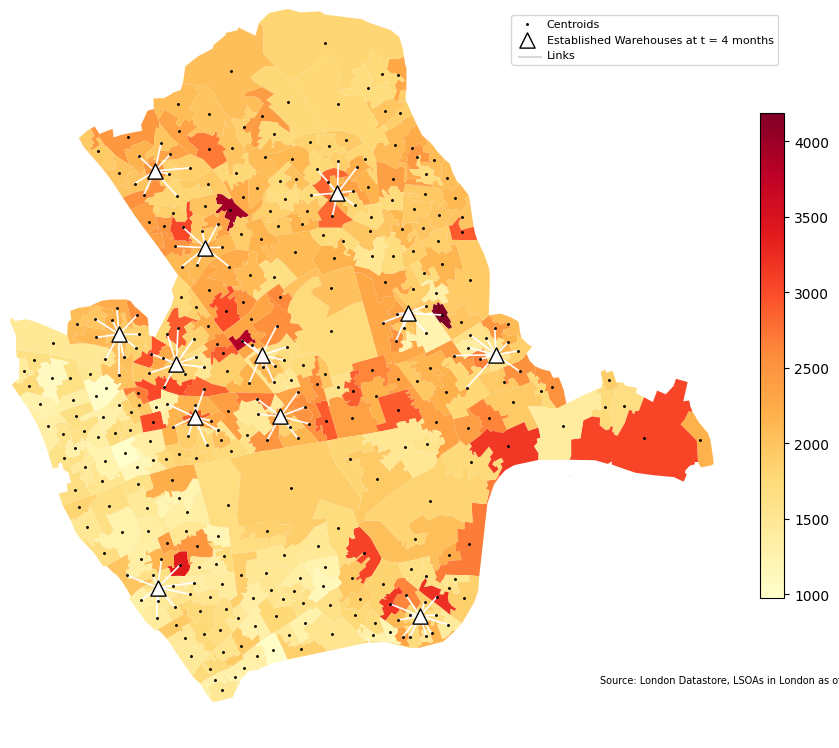

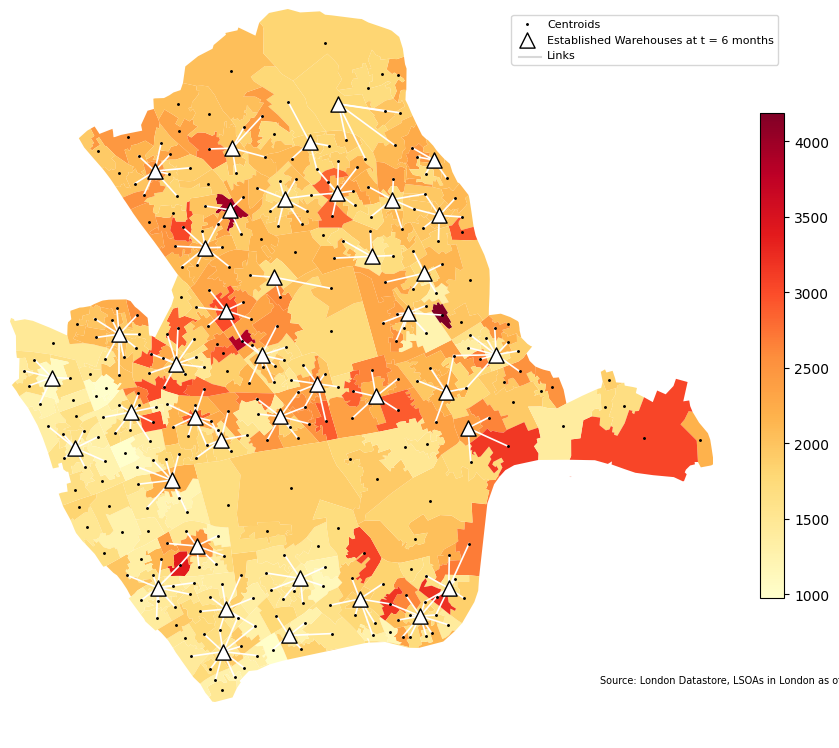

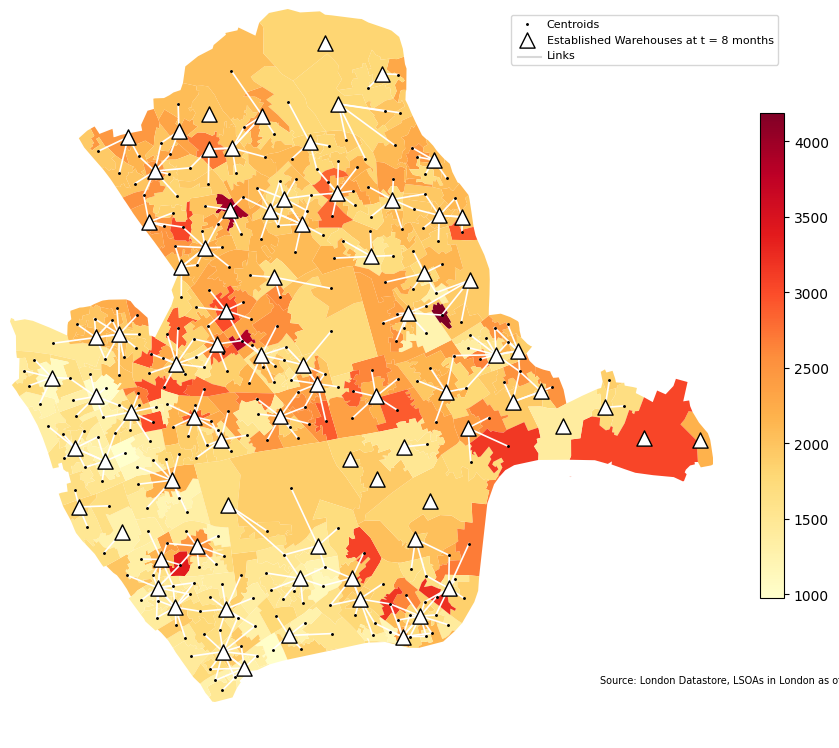

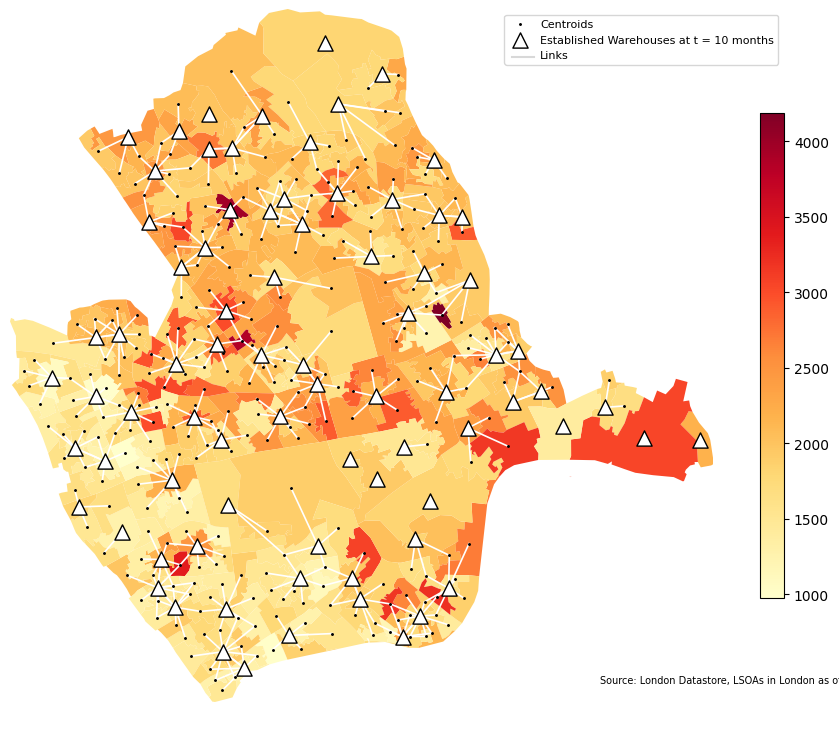

In [38]:
t=[2,4,6,8,10] #Months to be looping over

for month in t:
        #initial profit is set as profit for months 1 and 2 (TASK 2.2)
    profit_new=profit; D=[]; t=month;
    l_code_list = list(ldn_df['lsoa_code'].values)
    P = dict(zip(l_code_list,list(ldn_df['pop'].values)))  

    for i in l_code_list:
        D.append((P[i]*math.log10(3+3*month))/10)

    D=dict(zip(l_code_list,D))

    Lt = L[:]
    enum_warehouses = enumerate(warehouses)

    for counter1,code1 in enum_warehouses:
        enum_Lt = enumerate(Lt)
        for counter2,code2 in enum_Lt:
            if code1==code2:
                Lt.pop(counter2)
    Nt = N[:]
    enum_neighbourhoods = enumerate(neighbourhoods)

    for counter1,code1 in enum_neighbourhoods:
        enum_Nt = enumerate(Nt)
        for counter2,code2 in enum_Nt:
            if code1==code2:
                Nt.pop(counter2)      

    prob = LpProblem('prob', LpMaximize)  
    x = LpVariable.dicts('x', Lt, cat=LpBinary)
    y = LpVariable.dicts('y', Nt, cat=LpBinary)
    prob += 20*lpSum([D[j]*y[j]] for j in Nt) - Ci*lpSum(x[i] for i in Lt)
    prob +=  lpSum(Ci*x[i] for i in Lt) <= 0.15*profit_new

    for i in Lt:
        for j in Nt:
            if j in A[i]:

                prob += A[i][j]*x[i] <= y[j]

    for j in Nt:
        prob += y[j] <= lpSum(A[i][j]*x[i] for i in Lt if j in A[i] if i in A.keys() )

    status = prob.solve()
    #print(f'STATUS\n{LpStatus[status]}\n')


    warehouses_increment = []; neighbourhood_increment=[]

    for v in list(x.values()):
        #v_st = int(v.name.replace('v_x_',''))
        if v.varValue== 1:
            warehouses.append(v.name.replace('x_',''))
            warehouses_increment.append(v.name.replace('x_',''))

    for v in list(y.values()):
        #v_st = int(v.name.replace('v_x_',''))
        if v.varValue== 1:
            neighbourhoods.append(v.name.replace('y_',''))
            neighbourhood_increment.append(v.name.replace('y_',''))

    #Obtaining profit to be used for next iteration
    total_income = 20*sum(D[i] for i in neighbourhoods)
    profit = -Ci*len(warehouses)+total_income        
    marginal_profit = marginal_profit = prob.objective.value()
    print('For t= '+str(month)+' months')
    print('Profit = £')
    print(round(profit,2))
    print('')
    

    fig, ax = plt.subplots(1, figsize = (12,12))

    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    # Add a title
    #ax.set_title('Potential Warehouse Locations at t='+str(month), fontdict={'fontsize': '14', 'fontweight': '2'})

    # We will remove the axis for better presentation
    ax.axis('off') 

    # We will annotate and add source
    ax.annotate('Source: London Datastore, LSOAs in London as of 2011',xy=(.5, .07),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=7, color='k')

    # Plot using a rainbow colormap
    ldn_df.plot(ax=ax,alpha=1,column='pop', cmap='YlOrRd')

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=ldn_df['pop'].min(), vmax=ldn_df['pop'].max())) # Empty array for the data range
    cbar = fig.colorbar(sm, shrink=0.7)

    # All potential warehouse location
    ldn_df['centroids'].plot(ax=ax, markersize=1.2, color='k',marker='o',label='Centroids', zorder=120);

    #extarct all centroids 
    centroids_all = ldn_df

    #extarct centroids corresponding to warehouses at time t
    centroids_set = ldn_df[ldn_df['lsoa_code'].isin(warehouses)] 
    centroids_set['centroids'].plot(ax=ax, markersize=120, color='w',marker="^", edgecolor='black', zorder=120, label='Established Warehouses at t = ' +str(month)+' months')

    # Select centroids within rangelim km radius range from iterated centroids
    mydict={};
    for i in centroids_all.values.tolist():
        sel_centroids = { k: v for k, v in dist_dict_eligible.items() if k[0] == i }
        mydict.update(sel_centroids)

    #COVERAGE MATRIX
    locations = list(dict.fromkeys(dist_dict_eligible))
    locations = list(itertools.chain.from_iterable(locations))
    even = locations[::2] 
    odd= locations[1::2]
    index=np.ones(len(odd))
    index=index.tolist()
    index = [round(num) for num in index]
    from collections import defaultdict
    d = defaultdict(dict)
    for x, y, z in zip(even, odd, index):
        d[x][y] = z
    A=dict(d)

    # Connect the randomsingle centroid with the other chosen centroids
    for k1,v1 in centroids_set.set_index(['lsoa_code'])['centroids'].items():
        for k2,v2 in centroids_all.set_index(['lsoa_code'])['centroids'].items():
            if k2 in A[k1]:
                ax.plot([v1.x, v2.x],[v1.y,v2.y], color='white',alpha=1, linewidth=1.2)

    import matplotlib.patheffects as pe      
    plt.plot([], [], color='w', path_effects=[pe.SimpleLineShadow(shadow_color='grey'), pe.Normal()], label='Links')
    legend = ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1), prop={'size': 8})
    fig.set_size_inches(12, 9)
    fig.savefig("potential_locations{month}.png".format(month=month))